Carga de paquetes (y en el colab meter la imagen, habrá que quitar lo del google colab)

In [42]:
import pywt
import pywt.data
from PIL import Image
import numpy as np
import cv2 # Para leer imagenes y meterles bordes, contornos y cosas
#import easyocr #OCR que igual ni usamos
import pytesseract  # El ocr bueno
import matplotlib.pyplot as plt
import shutil
import os
import random
from skimage.transform import resize
from scipy.ndimage import rotate
try:
 from PIL import Image
except ImportError:
 import Image

import keras
import tensorflow
from tensorflow.keras import layers

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop, SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#reader = easyocr.Reader(['hi','en'])


In [18]:
# Carga imagen
image_path = "data\images\WhatsApp Image 2023-11-19 at 17.21.41.jpeg"
image = Image.open(image_path)

In [29]:
grayscale_original = image.convert("L")
img_orig = np.array(grayscale_original)
alt, anch = img_orig.shape
print(alt, anch)

2016 1512


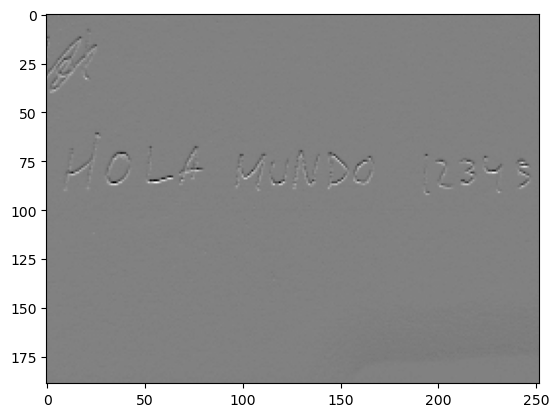

In [45]:
# Wavelet multinivel sin haber hecho el ganso como antes
multi_lvl = 3
coeffs = pywt.wavedec2(img_orig, 'haar', level = multi_lvl)
LL = coeffs[0]
# seleccionar nivel de detalles deseados desde 1 hasta multi_lvl
(LH, HL, HH) = coeffs[1]

# # Level coeffs
# print(len(coeffs) - 1)

# # Seleccionar que detalles no se quieren en la reconstrucción(aqui quito los detalles del nivel 1)
# eli_lvl = 1
# coeffs[-eli_lvl] = tuple([np.zeros_like(v) for v in coeffs[-eli_lvl]])

# # Reconstrucción imagen
# img_rec = pywt.waverec2(coeffs, 'haar')
HL = rotate(HL, 90, reshape = True) #SOLO SI LA IMAGEN ESTÁ ROTADA
plt.imshow(HL, cmap='gray')
plt.show()
imagen_wav = HL.copy()

In [53]:
imagen_wav

array([[ 5.50000000e+00,  5.50000000e+00,  3.00000000e+00, ...,
        -5.25000000e+00,  2.64348846e-15,  1.11365520e-16],
       [ 1.10000000e+01, -3.78418793e-16,  1.04248373e-15, ...,
         7.75000000e+00, -1.68499925e-15,  5.37500000e+00],
       [-7.37500000e+00,  5.00000000e+00, -5.25000000e+00, ...,
         5.12500000e+00,  1.07500000e+01,  1.12500000e+01],
       ...,
       [-3.00000000e+00, -5.00000000e+00,  6.37825818e-16, ...,
         3.12652516e-16, -3.58778726e-17, -2.58554343e-17],
       [-1.47315225e-15,  2.50000000e+00, -5.50000000e+00, ...,
         6.00000000e+00, -5.31627791e-16,  8.72387182e-16],
       [-5.50000000e+00, -5.50000000e+00, -3.75000000e+00, ...,
         3.51078003e-16, -3.48524920e-16,  4.75000000e+00]])

<function matplotlib.pyplot.show(close=None, block=None)>

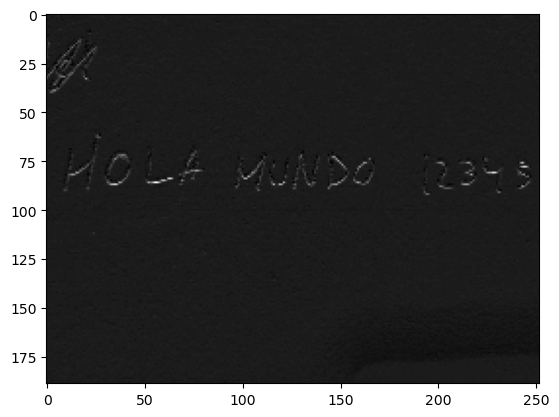

In [57]:
#Filtro blanco sobre negro (ajustar threshold_value hasta que se vea bien la imagen)
threshold_value = -50

mask = (imagen_wav >= threshold_value).astype(np.uint8) * 255
masked_image = cv2.bitwise_and(imagen_wav, imagen_wav, mask=mask)
plt.imshow(masked_image, cmap="gray")
plt.show

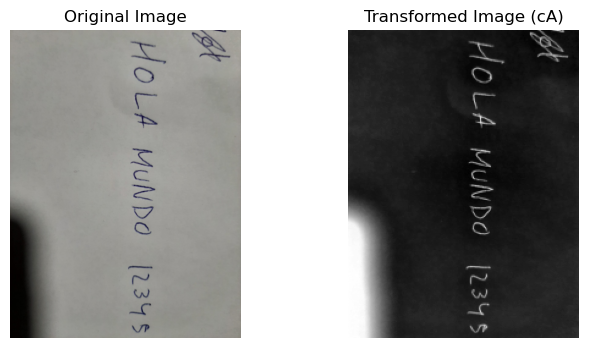

<function matplotlib.pyplot.show(close=None, block=None)>

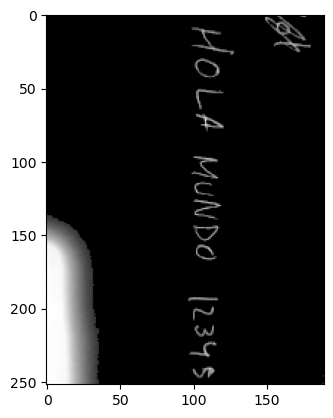

In [65]:
cA = coeffs[0]
normalized_cA = (cA - np.min(cA)) / (np.max(cA) - np.min(cA))
inverted_cA = 1 - normalized_cA
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(inverted_cA, cmap='gray')
plt.title('Transformed Image (cA)')
plt.axis('off')

plt.show()

threshold_value = .2

mask = (inverted_cA >= threshold_value).astype(np.uint8) * 255
masked_image = cv2.bitwise_and(inverted_cA, inverted_cA, mask=mask)
plt.imshow(masked_image, cmap="gray")
plt.show

In [ ]:
masked_image = rotate(masked_image, 90, reshape = True)

1/1 [==============================] - 0s 14ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

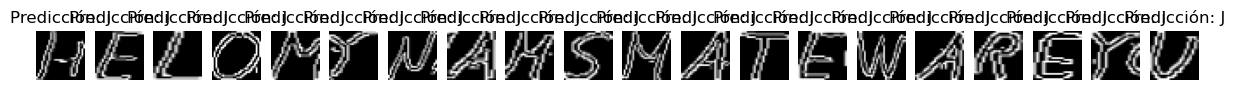

In [15]:
ed_model_02 = tensorflow.keras.models.load_model('modelos/modelo_C_02.keras')

LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

index_to_label = {i: label for i, label in enumerate(LABELS)}

# Convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar umbralización o técnicas de binarización si es necesario

# Aplicar un filtro de suavizado o técnicas de eliminación de ruido si es necesario

# Detección de bordes con el algoritmo Canny
edged_image = cv2.Canny(gray, threshold1=30, threshold2=100)  # Ajusta los valores de umbral según tu imagen

# Aplicar Connected Component Analysis

regiones_recortadas = []
_, labels, stats, centroids = cv2.connectedComponentsWithStats(edged_image)

# Iterar a través de los componentes conectados y filtrar por ciertas estadísticas
for i, stat in enumerate(stats):
    # Filtrar componentes conectados basados en ciertas estadísticas (área, posición, etc.)
    # Por ejemplo, puedes filtrar por el área para eliminar componentes pequeños o grandes
    area = stat[cv2.CC_STAT_AREA]
    if area > 100 and area < 700:  # Cambia estos valores según tus necesidades
        # Dibujar un rectángulo alrededor del componente conectado
        x, y, w, h = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT]
        # cv2.rectangle(edged_image, (x, y), (x + w, y + h), (255, 0, 0), 2) #Diguja los rectángulos en la imagen

        # Recortar la región del rectángulo de la imagen original
        roi = edged_image[y:y+h, x:x+w]
        centroide = centroids[i]
        regiones_recortadas.append((roi, centroide))

# Ordenar las regiones por las coordenadas de los centroides
regiones_ordenadas = sorted(regiones_recortadas, key=lambda x: (x[1][0], x[1][1]))

fig, axs = plt.subplots(1, len(regiones_ordenadas), figsize=(15, 3))

# Guardar las letras en orden de aparición en la carpeta "fotos"
for i, (region, _) in enumerate(regiones_ordenadas):
    resized_matrix = resize(region, (28, 28), anti_aliasing=False)
    imagen_array = np.array(resized_matrix).reshape(1, 784)
    imagen_normalizada = imagen_array.astype('float32') / 255.0
    prediction = ed_model_02.predict(imagen_normalizada)
    predicted_class = np.argmax(prediction)
    predicted_label = index_to_label[predicted_class]
    # print(predicted_label)
    # plt.imshow(region, cmap='gray')
    # title = f'Predicción: {predicted_label}'
    # plt.title(title)
    axs[i].imshow(imagen_normalizada.reshape(28, 28), cmap='gray')
    axs[i].axis('off')  # Turn off axis labels
    axs[i].set_title(f'Predicción: {predicted_label}')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

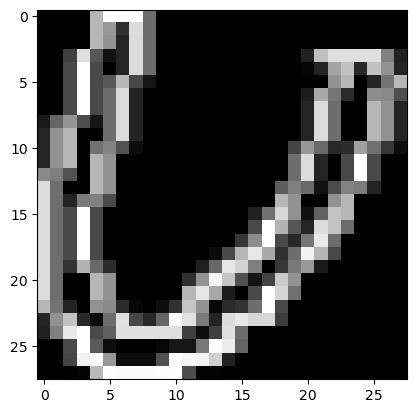

In [16]:
plt.imshow(imagen_normalizada.reshape(28, 28), cmap= "gray")
plt.show

1/1 [==============================] - 0s 29ms/step
J


<function matplotlib.pyplot.show(close=None, block=None)>

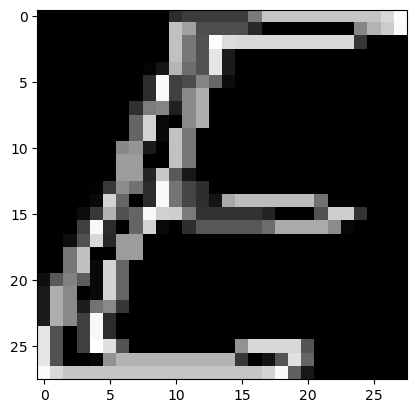

In [20]:
imagen_prueba, _ = regiones_ordenadas[1]

plt.imshow(imagen_prueba, cmap= "gray")
plt.show

resized_matrix = resize(imagen_prueba, (28, 28), anti_aliasing=False)
imagen_array = np.array(resized_matrix).reshape(1, 784)
imagen_normalizada = imagen_array.astype('float32') / 255.0
prediction = ed_model_02.predict(imagen_normalizada)
predicted_class = np.argmax(prediction)
predicted_label = index_to_label[predicted_class]
print(predicted_label)

plt.imshow(imagen_normalizada.reshape(28, 28), cmap="gray")
plt.show